In [6]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.sparse import bsr_matrix, coo_matrix
from scipy.sparse.linalg import eigsh
import joblib
from joblib import Parallel, delayed
import itertools
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.decomposition import PCA
from tqdm import tqdm
import contextlib
import copy
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

import sys
import os
sys.path.insert(1, os.path.dirname(os.getcwd()))

In [7]:
# support functions
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [8]:
def construct_adjacency_matrix(X, n):
    k = X.shape[0]
    W = np.zeros((k, k))
    neigh = NearestNeighbors(n_neighbors=n+1).fit(X)
    neighbors = neigh.kneighbors(X, n_neighbors=n+1, return_distance=False)[:, 1:]
    for i in range(k):
        W[i, neighbors[i]] = 1
    W = coo_matrix(W)
    W = W + W.transpose()
    W = W.sign()
    return W

def train_and_evaluate(v, s, labels):
    E = v[:s]
    conf = []
    for label in np.unique(labels):
        Y = np.copy(labels)
        Y[labels == label] = 1
        Y[labels != label] = -1
        a = np.linalg.pinv(E) @ Y[:s]
        conf.append(np.sum(v[s:] * a, axis=1).tolist())
    conf = np.array(conf)
    pred_labels = np.argmax(conf, axis=0)
    return np.mean(pred_labels != labels[s:])

def train_and_evaluate_knn(X, s, labels):
    k_vals = [5]
    errors = []
    for k in k_vals:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(X[:s], labels[:s])
        pred_labels = neigh.predict(X[s:])
        errors.append(np.mean(pred_labels != labels[s:]))
    return min(errors)

In [9]:
# load data
data = sio.loadmat("../datasets/TrainImages.mat")['TrainImages']
data = data/255.0
data = data.reshape(60000, 28*28)
X = PCA(n_components=100).fit_transform(data)

labels = sio.loadmat("../datasets/TrainImageLabels.mat")['Labels']
labels = np.array(labels, dtype='int').squeeze()
Y = np.copy(labels)

#### Effect of the number of eigenfunctions used

In [54]:
# set parameters
n = 8
p_list = [4, 10, 20, 30, 40, 50, 70, 100, 120, 150, 180, 200, 250]
s_list = [20, 50, 100, 500, 1000, 5000]
num_reps = 20

In [55]:
# compute the adjancency matrices and the graph Laplacians
num_points_list = [10000]
v_list = []
for num_points in num_points_list:
    W = construct_adjacency_matrix(X[:num_points], n)
    d = np.array(np.sum(W, axis=1)).squeeze()
    D = coo_matrix(W.shape)
    D.setdiag(d)
    L = D - W

    # compute first p eigenvectors with smallest eigenvalues
    _ , v = eigsh(L, k=p_list[-1], which='SM')
    v = np.real(v)
    v_list.append(v)

In [56]:
# train and evaluate
def loop(X, v_list, s, p, labels):
    v = v_list[0][:, :p]
    idx = np.random.permutation(10000)
    error = train_and_evaluate(v[idx], s, labels[idx])
    return error

mean_error_list = np.zeros((len(p_list), len(s_list)))
std_error_list = np.zeros((len(p_list), len(s_list)))

for j, p in enumerate(p_list):
    for i, s in enumerate(s_list):
        with tqdm_joblib(tqdm(desc="Run reps", total=num_reps)) as progress_bar:
            buffer = np.array(Parallel(n_jobs=-1)(delayed(loop)(X, v_list, s, p, labels) for r in range(num_reps)))
        mean_error_list[j, i] = np.mean(buffer, axis=0)
        std_error_list[j, i] = np.std(buffer, axis=0)

Run reps: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


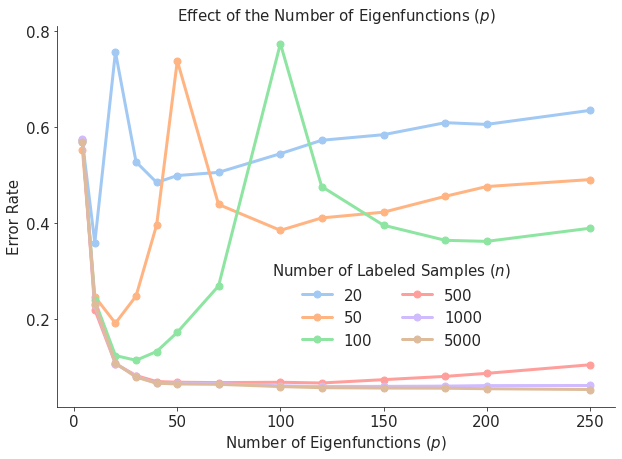

In [57]:
# plot
fontsize=15
labelsize=15

fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("pastel")
s_list = np.array(s_list)
for i in range(len(s_list)):
    errors = mean_error_list[:, i]
    ax.plot(p_list, errors, lw=3, marker='o', markersize=7, label="{}".format(s_list[i]))
# ax.set_xscale('log')
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Eigenfunctions ($p$)", fontsize=fontsize)
ax.set_ylabel("Error Rate", fontsize=15)
leg = ax.legend(fontsize=fontsize, frameon=False, ncol=2, loc=8, bbox_to_anchor=(0.6, 0.12))
leg.set_title(r"Number of Labeled Samples ($n$)", prop={'size':fontsize})
ax.set_title(r"Effect of the Number of Eigenfunctions ($p$)", fontsize=fontsize)

ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()
plt.show()

In [58]:
fig.savefig("figures/4-effect-of-num-eigenfuncs.pdf", bbox_inches='tight')

In [59]:
np.save("results/3-effect-of-num-eigenfuncs.npy", mean_error_list)

#### Effect of the number of nearest neighbors used

In [41]:
# set parameters
n_list = [1, 2, 4, 6, 8, 10, 12]
p = 100
s_list = [20, 50, 100, 500, 1000, 5000]
num_reps = 20

In [42]:
# compute the adjancency matrices and the graph Laplacians
num_points = 10000
v_list = []
for n in n_list:
    W = construct_adjacency_matrix(X[:num_points], n)
    d = np.array(np.sum(W, axis=1)).squeeze()
    D = coo_matrix(W.shape)
    D.setdiag(d)
    L = D - W

    # compute first p eigenvectors with smallest eigenvalues
    _ , v = eigsh(L, k=p_list[-1], which='SM')
    v = np.real(v)
    v_list.append(v)

In [ ]:
# train and evaluate
def loop(X, v, s, p, labels):
    p = min(s // 5, p)
    v = v[:, :p]
    idx = np.random.permutation(10000)
    error = train_and_evaluate(v[idx], s, labels[idx])
    return error

mean_error_list = np.zeros((len(n_list), len(s_list)))
std_error_list = np.zeros((len(n_list), len(s_list)))

for j, n in enumerate(n_list):
    for i, s in enumerate(s_list):
        with tqdm_joblib(tqdm(desc="Run reps", total=num_reps)) as progress_bar:
            buffer = np.array(Parallel(n_jobs=-1)(delayed(loop)(X, v_list[j], s, p, labels) for r in range(num_reps)))
        mean_error_list[j, i] = np.mean(buffer, axis=0)
        std_error_list[j, i] = np.std(buffer, axis=0)

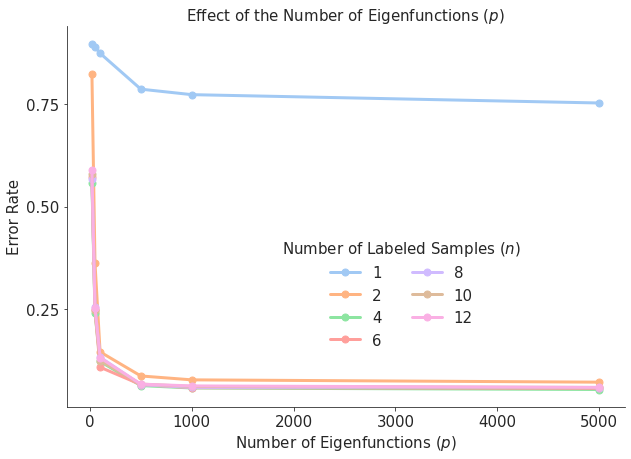

In [52]:
# plot
fontsize=15
labelsize=15

fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("pastel")
s_list = np.array(s_list)
for i in range(len(n_list)):
    errors = mean_error_list[i, :]
    ax.plot(s_list, errors, lw=3, marker='o', markersize=7, label="{}".format(n_list[i]))
# ax.set_xscale('log')
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Eigenfunctions ($p$)", fontsize=fontsize)
ax.set_ylabel("Error Rate", fontsize=15)
leg = ax.legend(fontsize=fontsize, frameon=False, ncol=2, loc=8, bbox_to_anchor=(0.6, 0.12))
leg.set_title(r"Number of Labeled Samples ($n$)", prop={'size':fontsize})
ax.set_title(r"Effect of the Number of Eigenfunctions ($p$)", fontsize=fontsize)

ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()
plt.show()

In [53]:
fig.savefig("figures/5-effect-of-num-neighbors.pdf", bbox_inches='tight')

In [47]:
np.save("results/4-effect-of-num-neighbors.npy", mean_error_list)

#### Number of labeled samples vs Numer of best eigenvalues

In [142]:
# set parameters
n = 8
p_list = [4, 10, 20, 30, 40, 50, 70, 100, 120, 150, 180, 200, 250]
s_list = [20, 50, 100, 500, 1000, 5000, 10000, 20000]
num_reps = 20

In [143]:
# compute the adjancency matrices and the graph Laplacians
num_points_list = [1000, 10000, 30000]
v_list = []
for num_points in num_points_list:
    W = construct_adjacency_matrix(X[:num_points], n)
    d = np.array(np.sum(W, axis=1)).squeeze()
    D = coo_matrix(W.shape)
    D.setdiag(d)
    L = D - W

    # compute first p eigenvectors with smallest eigenvalues
    _ , v = eigsh(L, k=p_list[-1], which='SM')
    v = np.real(v)
    v_list.append(v)

In [144]:
# train and evaluate
def loop(X, v_list, s, p, labels):
    error_lssl_1k = -1
    if s < 1000:
        v = v_list[0][:, :p]
        idx = np.random.permutation(1000)
        error_lssl_1k = train_and_evaluate(v[idx], s, labels[idx])

    error_lssl_10k = -1
    if s < 10000:
        v = v_list[1][:, :p]
        idx = np.random.permutation(10000)
        error_lssl_10k = train_and_evaluate(v[idx], s, labels[idx])

    error_lssl_30k = -1
    if s < 30000:
        v = v_list[2][:, :p]
        idx = np.random.permutation(30000)
        error_lssl_30k = train_and_evaluate(v[idx], s, labels[idx])

    return [error_lssl_1k, error_lssl_10k, error_lssl_30k]

mean_error_list = np.zeros((len(p_list), len(s_list), 3))
std_error_list = np.zeros((len(p_list), len(s_list), 3))

for j, p in enumerate(p_list):
    for i, s in enumerate(s_list):
        with tqdm_joblib(tqdm(desc="Run reps", total=num_reps)) as progress_bar:
            buffer = np.array(Parallel(n_jobs=-1)(delayed(loop)(X, v_list, s, p, labels) for r in range(num_reps)))
        mean_error_list[j, i, :] = np.mean(buffer, axis=0)
        std_error_list[j, i, :] = np.std(buffer, axis=0)

Run reps: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


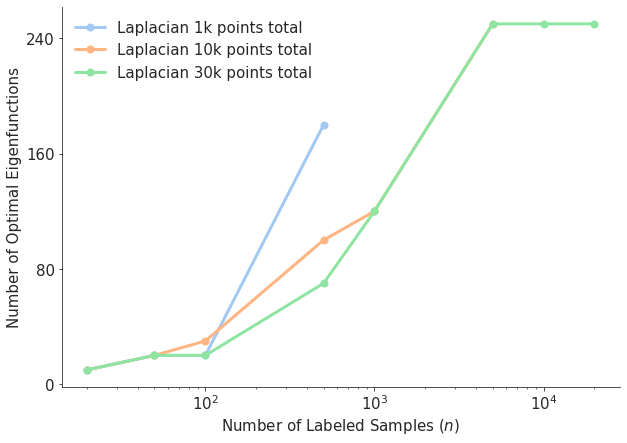

In [160]:
# plot
fontsize=15
labelsize=15

fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("pastel")
s_list = np.array(s_list)
p_list = np.array(p_list)
name_list = ["Laplacian 1k points total",
             "Laplacian 10k points total",
             "Laplacian 30k points total"]
n_list = [1000, 10000, 30000]
for i in range(len(n_list)):
    errors = mean_error_list[:,:, i]
    idx = np.where(s_list < n_list[i])[0]
    best_p = np.array([p_list[x] for x in np.argmin(errors[:, idx], axis=0)])
    ax.plot(s_list[idx], best_p, lw=3, marker='o', markersize=7, label=name_list[i])
ax.set_xscale('log')
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Labeled Samples ($n$)", fontsize=fontsize)
ax.set_ylabel("Number of Optimal Eigenfunctions", fontsize=15)
leg = ax.legend(fontsize=fontsize, frameon=False)
ax.set_title(r"Effect of the Number of Eigenfunctions ($p$)", fontsize=fontsize)

ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()
plt.show()

In [163]:
np.save("results/7-optimal-num-eigenfuncs.npy", np.array(mean_error_list))

In [164]:
fig.savefig("figures/7-optimal-num-eigenfuncs.pdf", bbox_inches='tight')

#### Time complexity and memory complexity

In [10]:
import time

In [16]:
# compute the adjancency matrices and the graph Laplacians
n = 8
num_points_list = [50, 100, 500, 1000, 5000, 10000]
p = 30
graph_time = []
eig_time = []
for num_points in num_points_list:
    t1 = time.time()
    W = construct_adjacency_matrix(X[:num_points], n)
    t2 = time.time()
    graph_time.append(t2-t1)

    d = np.array(np.sum(W, axis=1)).squeeze()
    D = coo_matrix(W.shape)
    D.setdiag(d)
    L = D - W

    # compute first p eigenvectors with smallest eigenvalues
    t1 = time.time()
    _ , v = eigsh(L, k=p, which='SM')
    t2 = time.time()
    eig_time.append(t2-t1)

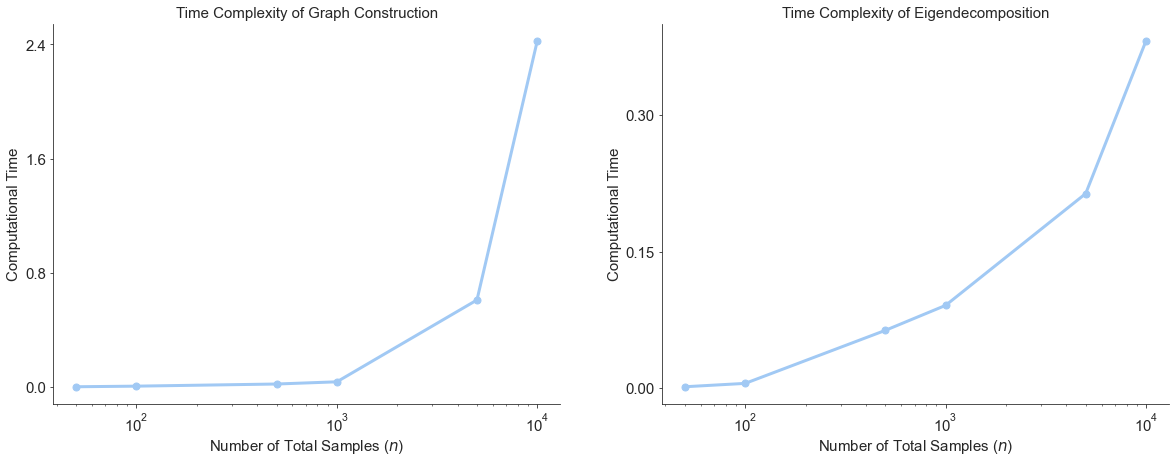

In [14]:
# plot
fontsize=15
labelsize=15

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("pastel")

ax = axes[0]
ax.plot(num_points_list, graph_time, lw=3, marker='o', markersize=7)
ax.set_xscale('log')
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Total Samples ($n$)", fontsize=fontsize)
ax.set_ylabel("Computational Time", fontsize=15)
ax.set_title(r"Time Complexity of Graph Construction", fontsize=fontsize)
ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()

ax = axes[1]
ax.plot(num_points_list, eig_time, lw=3, marker='o', markersize=7)
ax.set_xscale('log')
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Total Samples ($n$)", fontsize=fontsize)
ax.set_ylabel("Computational Time", fontsize=15)
ax.set_title(r"Time Complexity of Eigendecomposition", fontsize=fontsize)
ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()

plt.show()

In [70]:
fig.savefig("figures/6-complexity-analysis.pdf", bbox_inches='tight')

In [71]:
np.save("results/5-graph-time-complexity.npy", np.array(graph_time))
np.save("results/6-eig-time-complexity.npy", np.array(eig_time))

#### Final Figure

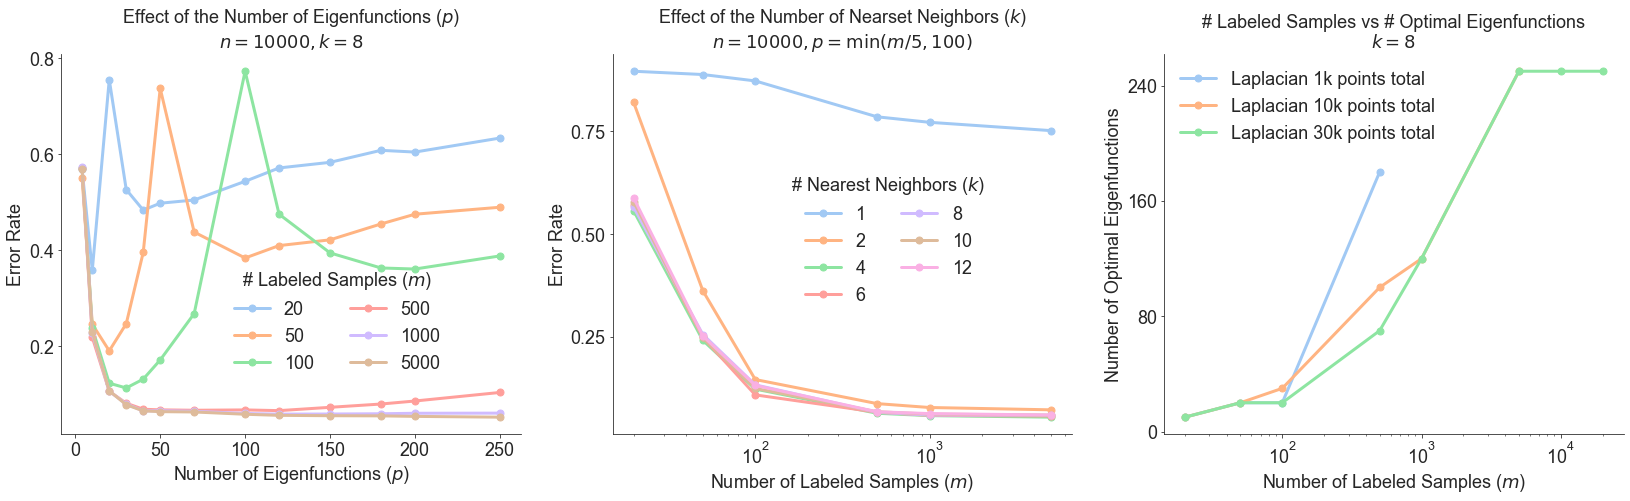

In [4]:
# plot
fontsize=18
labelsize=18

fig, axes = plt.subplots(1, 3, figsize=(28, 7))
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("pastel")

ax = axes[0]
s_list = [20, 50, 100, 500, 1000, 5000]
p_list = [4, 10, 20, 30, 40, 50, 70, 100, 120, 150, 180, 200, 250]
s_list = np.array(s_list)
mean_error_list = np.load("results/3-effect-of-num-eigenfuncs.npy")
for i in range(len(s_list)):
    errors = mean_error_list[:, i]
    ax.plot(p_list, errors, lw=3, marker='o', markersize=7, label="{}".format(s_list[i]))
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Eigenfunctions ($p$)", fontsize=fontsize)
ax.set_ylabel("Error Rate", fontsize=fontsize)
leg = ax.legend(fontsize=fontsize, frameon=False, ncol=2, loc=8, bbox_to_anchor=(0.6, 0.12))
leg.set_title(r"# Labeled Samples ($m$)", prop={'size':fontsize})
ax.set_title(r"Effect of the Number of Eigenfunctions ($p$)" + "\n" + r"$n=10000, k=8$", fontsize=fontsize)
ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()

ax = axes[1]
s_list = np.array(s_list)
n_list = [1, 2, 4, 6, 8, 10, 12]
mean_error_list = np.load("results/4-effect-of-num-neighbors.npy")
for i in range(len(n_list)):
    errors = mean_error_list[i, :]
    ax.plot(s_list, errors, lw=3, marker='o', markersize=7, label="{}".format(n_list[i]))
ax.set_xscale('log')
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Labeled Samples ($m$)", fontsize=fontsize)
ax.set_ylabel("Error Rate", fontsize=fontsize)
leg = ax.legend(fontsize=fontsize, frameon=False, ncol=2, loc=8, bbox_to_anchor=(0.6, 0.3))
leg.set_title(r"# Nearest Neighbors ($k$)", prop={'size':fontsize})
ax.set_title(r"Effect of the Number of Nearset Neighbors ($k$)" + "\n" + r"$n=10000, p=\min(m/5, 100)$", fontsize=fontsize)
ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()

ax = axes[2]
s_list = [20, 50, 100, 500, 1000, 5000, 10000, 20000]
p_list = [4, 10, 20, 30, 40, 50, 70, 100, 120, 150, 180, 200, 250]
mean_error_list = np.load("results/7-optimal-num-eigenfuncs.npy")
s_list = np.array(s_list)
p_list = np.array(p_list)
name_list = ["Laplacian 1k points total",
             "Laplacian 10k points total",
             "Laplacian 30k points total"]
n_list = [1000, 10000, 30000]
for i in range(len(n_list)):
    errors = mean_error_list[:,:, i]
    idx = np.where(s_list < n_list[i])[0]
    best_p = np.array([p_list[x] for x in np.argmin(errors[:, idx], axis=0)])
    ax.plot(s_list[idx], best_p, lw=3, marker='o', markersize=7, label=name_list[i])
ax.set_xscale('log')
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Labeled Samples ($m$)", fontsize=fontsize)
ax.set_ylabel("Number of Optimal Eigenfunctions", fontsize=fontsize)
leg = ax.legend(fontsize=fontsize, frameon=False)
ax.set_title(r"# Labeled Samples vs # Optimal Eigenfunctions" + "\n" + r"$k=8$", fontsize=fontsize)
ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()

plt.show()

In [176]:
fig.savefig("../report/figures/Ashwin/3-algo-analysis.pdf", bbox_inches='tight')

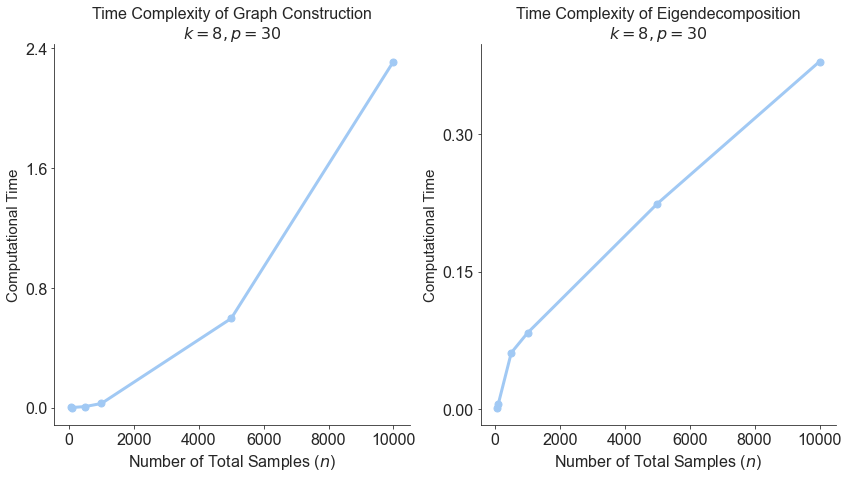

In [17]:
# plot
fontsize=16
labelsize=16
num_points_list = [50, 100, 500, 1000, 5000, 10000]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
ax = axes[0]
ax.plot(num_points_list, graph_time, lw=3, marker='o', markersize=7)
# ax.set_xscale('log')
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Total Samples ($n$)", fontsize=fontsize)
ax.set_ylabel("Computational Time", fontsize=15)
ax.set_title(r"Time Complexity of Graph Construction" + "\n" + r"$k=8, p=30$", fontsize=fontsize)
ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()

ax = axes[1]
ax.plot(num_points_list, eig_time, lw=3, marker='o', markersize=7)
# ax.set_xscale('log')
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r"Number of Total Samples ($n$)", fontsize=fontsize)
ax.set_ylabel("Computational Time", fontsize=15)
ax.set_title(r"Time Complexity of Eigendecomposition" + "\n" + r"$k=8, p=30$", fontsize=fontsize)
ax.yaxis.set_major_locator(MaxNLocator(4))
sns.despine()

plt.show()

In [18]:
fig.savefig("../report/figures/Ashwin/4-complexity-analysis.pdf", bbox_inches='tight')